# Figure 1
## Measures of Heatwave Hazard with Trends

Notes:

Possible to add MERRA2 line to Fig 1A? What would be challenges with that?

``This is supplemental figure 1S.A``

Put the vertical lines for 30 year slopes back in for Fig 1A -- same as in the version in the presentation

``Done.``

Remove "Hatching indicates…" text for 1B. This will go in the caption.

``Done.``

Is it possible to calculate inflection point of 1b curve (with some error range)?

``Yes, it is added with the diamond and error bar.``

C/D/E/F --> may drop or put in supplement in slightly different form? Discuss with him based on the points that are worthwhile to make. I think C and D 
will be covered in some way by the inflection figure, but because inflection point is not the same for everywhere that highlights the ways in which C and D are a bit arbitrary. E is helpful in showing the total avoided HWF, but would be better to show true historical and true future…? And the absolute sum thing is a little bit funky…
``The regression path for explicitly showing the 'inflection' and minimum points was investigated, but was too confusing. The calculation is included at the bottom of the notebook, we will explore this further in the future if it proves ``

In [6]:
import xarray
from distributed import Client
import numpy as np
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


client = Client('localhost:8786')
client

<Client: 'tcp://146.6.192.149:8786' processes=10 threads=20, memory=186.26 GiB>

In [2]:
HW_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/HEAT_OUTPUTS/"

land_mask_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/LENS1/CESM1/all/001/day/LANDFRAC/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.200001-209912.nc"
land_mask = xarray.open_dataset(land_mask_path)["LANDFRAC"].mean(dim="time")

hw_mn_all_path = f"{HW_DIR}CESM1_LE_all_TREFHTMN_HW_METRICS.zarr"
hw_mn_xaer_path = f"{HW_DIR}CESM1_LE_xaer_TREFHTMN_HW_METRICS.zarr"
hw_mn_xghg_path = f"{HW_DIR}CESM1_LE_xghg_TREFHTMN_HW_METRICS.zarr"
OUTPUT_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/MERRA2/HEAT_OUTPUTS/"
hw_mn_merra_path = f"{OUTPUT_DIR}MERRA2_T2MMIN_HW_METRICS.zarr"


hw_mn_all = xarray.open_zarr(hw_mn_all_path)
hw_mn_xaer = xarray.open_zarr(hw_mn_xaer_path)
hw_mn_xghg = xarray.open_zarr(hw_mn_xghg_path)
hw_mn_merra = xarray.open_zarr(hw_mn_merra_path)


hw_mn_all_ts = hw_mn_all.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_all.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_xaer_ts = hw_mn_xaer.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_xaer.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_xghg_ts = hw_mn_xghg.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_xghg.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_merra_ts = hw_mn_merra.sel(percentile=0.9).where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_merra.lat))).mean(dim=["lat", "lon"]).compute()

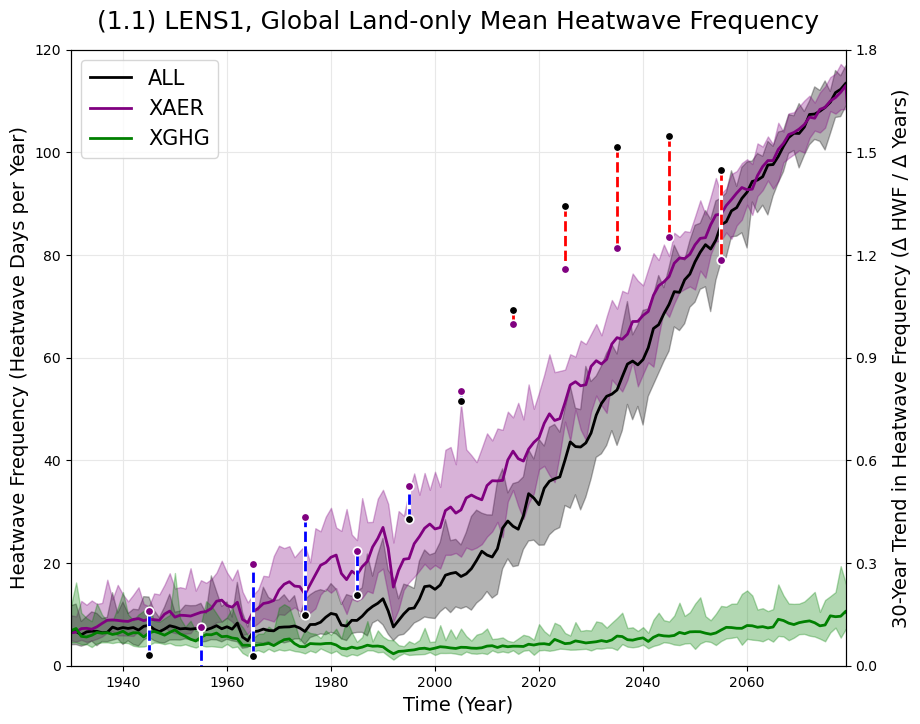

In [3]:
f_background_color = "#ffffff"
ax_background_color = "#ffffff"
grid_line_color = "#e8e8e8"
grid_line_lw = 0.8
all_color = "Black"
xaer_color = "Purple"
xghg_color = "Green"

regression_centers = np.arange(1945, 2065, 10)
all_regressions = np.zeros((2, regression_centers.size))
xaer_regressions = np.zeros((2, regression_centers.size))

for index, center in enumerate(regression_centers):
    hw_mn_all_ts_slice = hw_mn_all_ts["HWF"].sel(year=slice(center-15, center+14)).mean(dim="member")
    hw_mn_xaer_ts_slice = hw_mn_xaer_ts["HWF"].sel(year=slice(center-15, center+14)).mean(dim="member")

    all_regressions[:, index] = np.polyfit(hw_mn_all_ts_slice.year.values, hw_mn_all_ts_slice.values, 1)
    xaer_regressions[:, index] = np.polyfit(hw_mn_xaer_ts_slice.year.values, hw_mn_xaer_ts_slice.values, 1)

f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

f.patch.set_facecolor(f_background_color)
ax1.set_facecolor(ax_background_color)

for i in np.arange(1940, 2080, 20):
    ax1.axvline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)
for i in np.arange(0, 120, 20):
    ax1.axhline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)

hw_mn_all_ts["HWF"].mean(dim="member").plot(ax=ax1, color=all_color, linewidth=2, label="ALL")
hw_mn_xaer_ts["HWF"].mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=2, label="XAER")
hw_mn_xghg_ts["HWF"].mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=2, label="XGHG")

a = 0.3
ax1.fill_between(hw_mn_all_ts["HWF"].year.values, hw_mn_all_ts["HWF"].min(dim="member"), hw_mn_all_ts["HWF"].max("member"), alpha=a, color=all_color)
ax1.fill_between(hw_mn_xaer_ts["HWF"].year.values, hw_mn_xaer_ts["HWF"].min(dim="member"), hw_mn_xaer_ts["HWF"].max("member"), alpha=a, color=xaer_color)
ax1.fill_between(hw_mn_xghg_ts["HWF"].year.values, hw_mn_xghg_ts["HWF"].min(dim="member"), hw_mn_xghg_ts["HWF"].max("member"), alpha=a, color=xghg_color)

ax11 = ax1.twinx()

for index, center in enumerate(regression_centers):
    all_val = all_regressions[0, index]
    xaer_val = xaer_regressions[0, index]
    color = "Blue"
    if all_val > xaer_val:
        color = "Red"

    ax11.plot([center, center], [all_val,  xaer_val], linewidth=3, linestyle="-", color="White", zorder=0)
    ax11.plot([center, center], [all_val,  xaer_val], linewidth=2, linestyle="--", color=color, zorder=5)

s = 40
ax11.scatter(regression_centers, all_regressions[0, :], color="White", s=s, zorder=10)
ax11.scatter(regression_centers, xaer_regressions[0, :], color="White", s=s, zorder=10)

s = 15
ax11.scatter(regression_centers, all_regressions[0, :], color=all_color, s=s, zorder=15)
ax11.scatter(regression_centers, xaer_regressions[0, :], color=xaer_color, s=s, zorder=15)

ax11.set_yticks(np.arange(0, 2, 0.3))
ax11.set_ylim(0, 1.8)
ax11.set_ylabel("30-Year Trend in Heatwave Frequency (Δ HWF / Δ Years)", fontsize=14, labelpad=10)

ax1.legend(fontsize=15)
ax1.set_xlim(1930, 2079)
ax1.set_ylim(0, 120)
ax1.set_title("(1.1) LENS1, Global Land-only Mean Heatwave Frequency", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Heatwave Frequency (Heatwave Days per Year)", fontsize=14)

f.show()

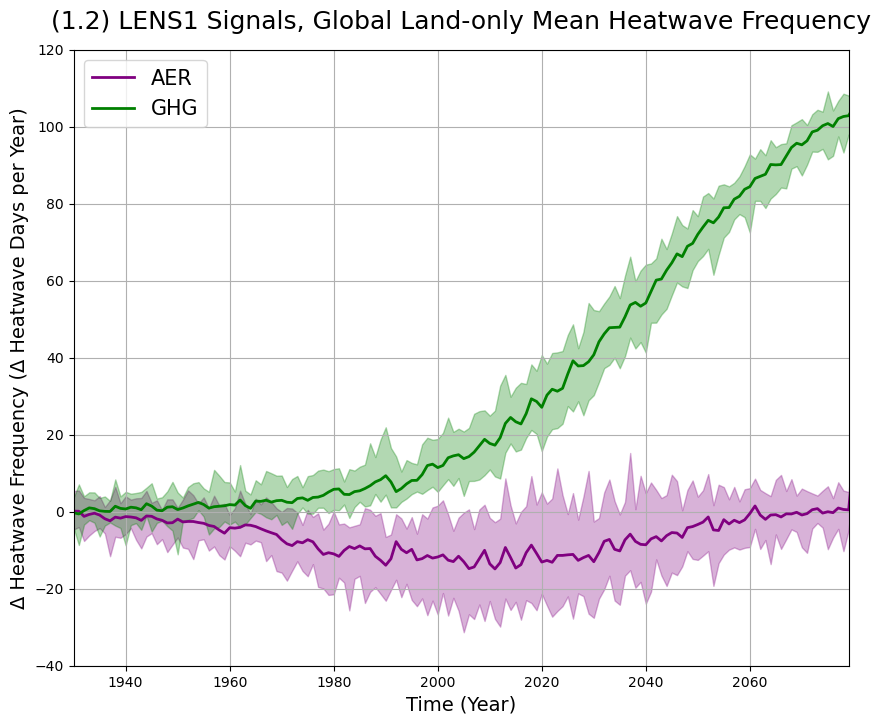

In [4]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

hw_mn_aer_ts = hw_mn_all_ts["HWF"] - hw_mn_xaer_ts["HWF"]
hw_mn_ghg_ts = hw_mn_all_ts["HWF"] - hw_mn_xghg_ts["HWF"]

hw_mn_aer_ts.mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=2, label="AER")
hw_mn_ghg_ts.mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=2, label="GHG")

a = 0.3
ax1.fill_between(hw_mn_aer_ts.year.values, hw_mn_aer_ts.min(dim="member"), hw_mn_aer_ts.max("member"), alpha=a, color=xaer_color)
ax1.fill_between(hw_mn_aer_ts.year.values, hw_mn_ghg_ts.min(dim="member"), hw_mn_ghg_ts.max("member"), alpha=a, color=xghg_color)

# For displaying the regression analysis:
# slope_dist = []
# for index in range(20):
#     a, b, c = np.polyfit(hw_mn_aer_ts.sel(year=slice(1980, 2040)).year.values, hw_mn_aer_ts.sel(year=slice(1980, 2040)).sel(member=index).values, 2)
#     aer_min = -b / (2*a)
#     slope_dist.append(aer_min)

# y = -11
# a, b, c = np.polyfit(hw_mn_aer_ts.sel(year=slice(1980, 2040)).year.values, hw_mn_aer_ts.sel(year=slice(1980, 2040)).mean(dim="member").values, 2)
# ax1.plot(hw_mn_aer_ts.sel(year=slice(1980, 2040)).year.values, a*(hw_mn_aer_ts.sel(year=slice(1980, 2040)).year.values)**2 + b*hw_mn_aer_ts.sel(year=slice(1980, 2040)).year.values + c, linestyle="--", color="Red", linewidth=2)

# ax1.scatter(np.mean(slope_dist), y, color="White", marker="D", s=45, zorder=2)
# ax1.scatter(np.mean(slope_dist), y, color="Red", marker="D", s=30, zorder=3)
# ax1.plot([np.min(slope_dist), np.max(slope_dist)], [y, y], color="White", linewidth=3.5, zorder=2)
# ax1.plot([np.min(slope_dist), np.max(slope_dist)], [y, y], color="Red", linewidth=2, zorder=3)

ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(1930, 2079)
ax1.set_ylim(-40, 120)
ax1.set_title("(1.2) LENS1 Signals, Global Land-only Mean Heatwave Frequency", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Δ Heatwave Frequency (Δ Heatwave Days per Year)", fontsize=14)
f.show()

Below are the global minimum calculations for AER and GHG

In [93]:
hw_mn_aer_ts = hw_mn_all_ts["HWF"] - hw_mn_xaer_ts["HWF"]
hw_mn_ghg_ts = hw_mn_all_ts["HWF"] - hw_mn_xghg_ts["HWF"]

a, b, c = np.polyfit(np.tile(hw_mn_aer_ts.year.values, 20), hw_mn_aer_ts.values.flatten(), 2)
aer_min = -b / (2*a)
print(f"{aer_min}")
# a, b, c, d = np.polyfit(np.tile(hw_mn_ghg_ts.year.values, 20), hw_mn_ghg_ts.values.flatten(), 3)
# ghg_min = -b / (3*a)
# print(f"{ghg_min}")

slope_dist = []
for index in range(20):
    a, b, c, d = np.polyfit(hw_mn_ghg_ts.year.values, hw_mn_ghg_ts.sel(member=index).values, 3)
    aer_min = -b / (3*a)
    slope_dist.append(aer_min)
print(np.mean(slope_dist))

2001.3896714519356
3794.358008746874


### Slope Maps

In [58]:
hw_mn_aer_slope_1930_2005 = (hw_mn_all - hw_mn_xaer).sel(year=slice(1930, 2004), percentile=0.9).mean(dim="member").polyfit(dim="year", deg=1).compute()
hw_mn_aer_slope_2005_2080 = (hw_mn_all - hw_mn_xaer).sel(year=slice(2005, 2080), percentile=0.9).mean(dim="member").polyfit(dim="year", deg=1).compute()

Text(0.5, 1.0, 'Ensemble Mean AER Rate of Change in HWF, 2005-2080')

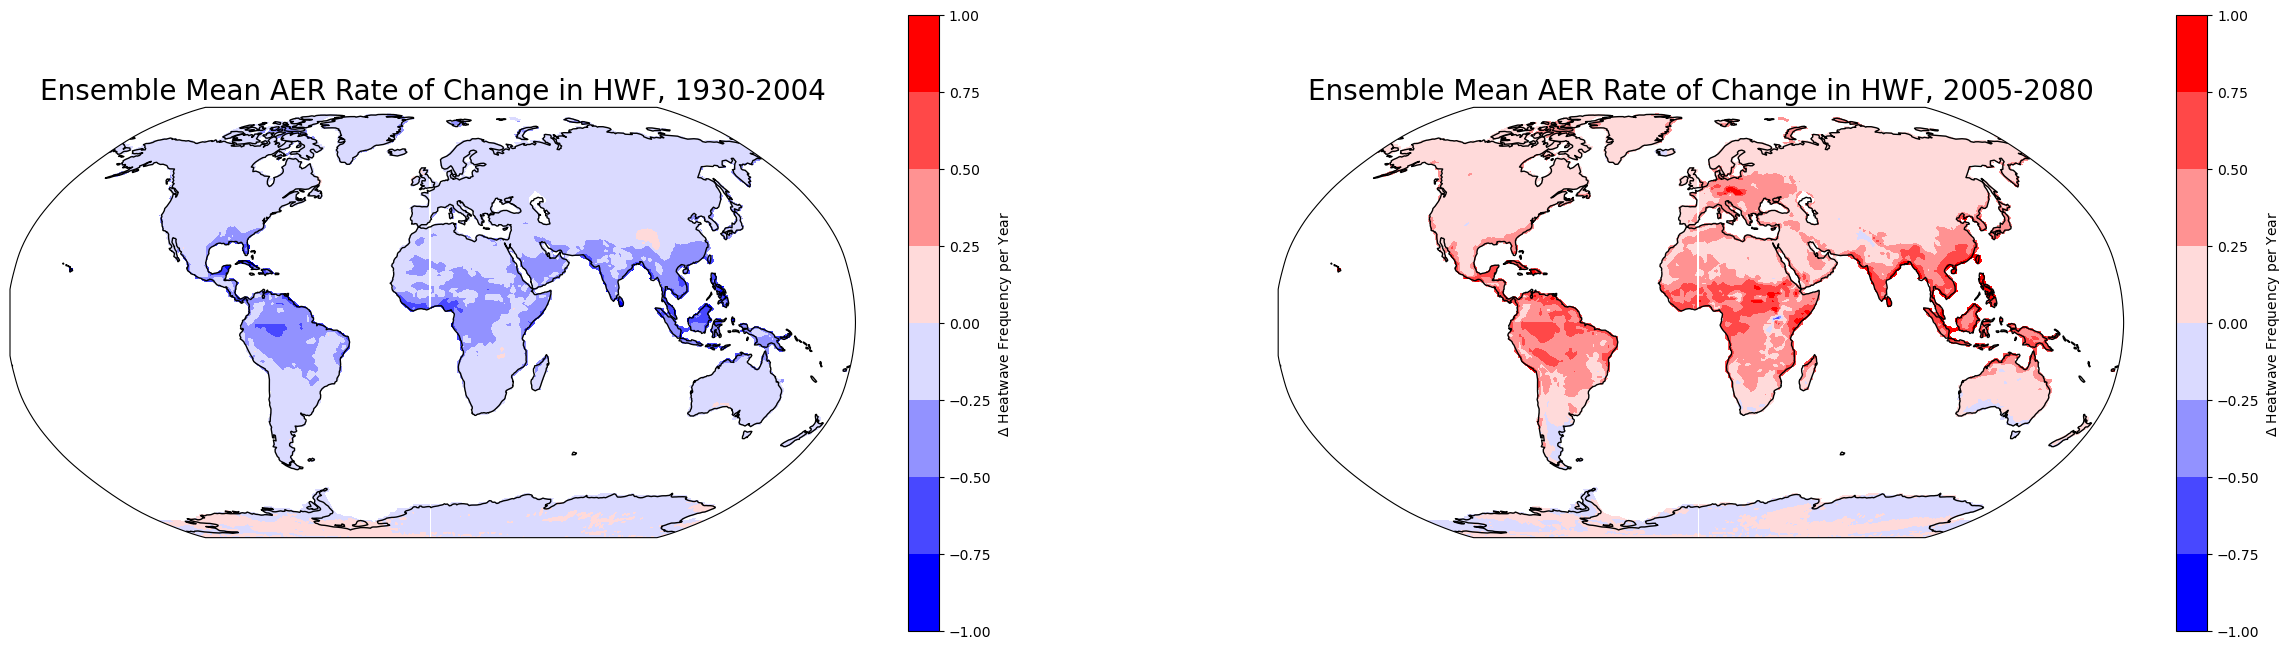

In [64]:
proj = ccrs.Robinson()
transform = ccrs.PlateCarree()
cmap = "bwr"
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8), facecolor='w', subplot_kw=dict(projection=proj))


levels = np.arange(-1, 1.1, 0.25)
hw_mn_aer_slope_1930_2005["HWF_polyfit_coefficients"].rename("$\\Delta$ Heatwave Frequency per Year").sel(degree=1).where(land_mask > 0).plot.contourf(ax=ax1, cmap="bwr", levels=levels, vmax=1, vmin=-1, transform=transform)
cbar = hw_mn_aer_slope_2005_2080["HWF_polyfit_coefficients"].rename("$\\Delta$ Heatwave Frequency per Year").sel(degree=1).where(land_mask > 0).plot.contourf(ax=ax2, cmap="bwr", levels=levels, vmax=1, vmin=-1, transform=transform, extend="neither")

ax1.coastlines()
ax1.set_title("Ensemble Mean AER Rate of Change in HWF, 1930-2004", fontsize=20)

ax2.coastlines()
ax2.set_title("Ensemble Mean AER Rate of Change in HWF, 2005-2080", fontsize=20)